# Advanced Machine Learning - Project 2
## Mountain Car Problem with Reinforcement Learning

- Eduardo Carneiro - 62515
- Til Dietrich - 62928

## Possibly useful resources:
- Hyperparameter tuning in RL: https://arxiv.org/pdf/2306.01324.pdf

# TODO
- hyper-parameter tuning for Q-Learning (e.g. grid search)
- understand if results from Q-Learn make any sense

- Deep-Q Learning

- use same initial state to better compare the two agents

- Reverb Package does not work on Windows. Thus, im running this notebook in VSCode through a WSL Window
- The next commands create an environment in the WSL with all the necessary packages

In [ ]:
!sudo apt install python3.10-venv
!python -m venv venv_AML_linux
!source venv_AML_linux/bin/activate

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
# Uncomment to install packages in collab or if necessary
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install gymnasium
!pip install seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns

import pyvirtualdisplay
import PIL

import reverb

import base64
import imageio
import IPython


import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
sns.set(style='whitegrid', palette='muted', context='paper')

## Table of Contents
### 1. The environment
### 2. Q-Learning
### 3. Deep-Q Learning

## 1. The environment

In [ ]:
# Implementation based on TP10 notebook
# Still needs checking

In [ ]:
# Load environment
env = gym.make("MountainCar-v0",render_mode='rgb_array')

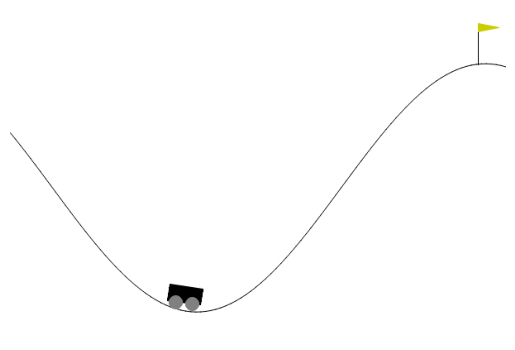

In [ ]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [ ]:
# Confirm observation and action space dimensions
# Link to documentation: https://gymnasium.farama.org/environments/classic_control/mountain_car/
print(env.observation_space, env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


The current state is always defined by the two parameters position (p) and velocity (v).

The action space is:
- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

## 1. Q-Learning

First, we define all necessary functions for better readibility

In [ ]:
# Function for discretizing the observation space, either by number of batches or by batch size
def discretize(interval, number_batches=-1, batch_percentage=0.1):

    sum = abs(interval[0]) + abs(interval[1])

    if number_batches != -1:
        batch_size = sum / number_batches
    else:
        batch_size = batch_percentage * sum

    return np.arange(interval[0], interval[1], batch_size)

In [ ]:
# Define functions for getting index of a batch (position and velocity)
def get_index_position_batch(position, position_batches):

    l = len(position_batches)

    for low in range(l):

        if position < position_batches[low]:
            return low-1

    return l-1

def get_index_velocity_batch(velocity, velocity_batches):

    l = len(velocity_batches)

    for low in range(l):

        if velocity < velocity_batches[low]:
            return low-1

    return l-1

In [ ]:
# Define epsilon greedy function
def epsilon_greedy(state, epsilon):
    global q_table

    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        # Assuming state is a tuple with (position, velocity)
        return np.argmax(q_table[state[0], state[1], :])

As we are working with Q-tables, we need to discretize the continuous space.

In the following, P denotes the number of discrete batches of the *position*, and V the number of discrete batches of *velocity*.

In [ ]:
BATCH_PERC = 0.01

position_batches = discretize((env.observation_space.low[0], env.observation_space.high[0]), batch_percentage=BATCH_PERC)
P = len(position_batches)

velocity_batches = discretize((env.observation_space.low[1], env.observation_space.high[1]), batch_percentage=BATCH_PERC)
V = len(velocity_batches)

print(P, position_batches)
print(V, velocity_batches)

100 [-1.20000005 -1.18200005 -1.16400005 -1.14600005 -1.12800004 -1.11000004
 -1.09200004 -1.07400004 -1.05600004 -1.03800004 -1.02000004 -1.00200004
 -0.98400004 -0.96600004 -0.94800004 -0.93000004 -0.91200004 -0.89400004
 -0.87600003 -0.85800003 -0.84000003 -0.82200003 -0.80400003 -0.78600003
 -0.76800003 -0.75000003 -0.73200003 -0.71400003 -0.69600003 -0.67800003
 -0.66000003 -0.64200003 -0.62400002 -0.60600002 -0.58800002 -0.57000002
 -0.55200002 -0.53400002 -0.51600002 -0.49800002 -0.48000002 -0.46200002
 -0.44400002 -0.42600002 -0.40800002 -0.39000002 -0.37200001 -0.35400001
 -0.33600001 -0.31800001 -0.30000001 -0.28200001 -0.26400001 -0.24600001
 -0.22800001 -0.21000001 -0.19200001 -0.17400001 -0.15600001 -0.13800001
 -0.12       -0.102      -0.084      -0.066      -0.048      -0.03
 -0.012       0.006       0.024       0.042       0.06        0.078
  0.096       0.114       0.13200001  0.15000001  0.16800001  0.18600001
  0.20400001  0.22200001  0.24000001  0.25800001  0.276000

In [ ]:
# TODO in the end, put all "global" parameters in one cell for easier manipulation ???

In [ ]:
q_table = np.zeros((P, V, env.action_space.n))
print(q_table.shape)

(100, 100, 3)


### Hyperparameters

In [ ]:
# Hyperparameters
alpha = 0.8 # Learning rate
gamma = 0.95
epsilon = 0.1
num_episodes = 10001
num_steps = 1000

In [ ]:
# grid search
# for alpha in [0.7, 0.8, 0.9]:
#     for gamma in [0.85, 0.9, 0.95]:
#         for epsilon in [0.05, 0.1, 0.15]:

arr_total_rewards = []
arr_steps = []
arr_done = np.zeros(num_episodes)

# Q-Learning Algorithm
# for each episode:
for i in range(num_episodes):

    # Initialize the state by resetting the environment, reward, and steps
    s, _ = env.reset()
    total_reward = 0
    steps = 0

    # Discretize the state
    s = [get_index_position_batch(s[0], position_batches), get_index_velocity_batch(s[1], velocity_batches)]

    #for each step in the episode
    for t in range(num_steps):

        # Select action using epsilon-greedy
        a = epsilon_greedy(s, epsilon)

        # Perform the selected action and store the next state information
        s_, r, done, _, _ = env.step(a)

        # Discretize s dash
        s_ = [get_index_position_batch(s_[0], position_batches), get_index_velocity_batch(s_[1], velocity_batches)]

        # First, select the action a dash which has a maximum Q value in the next state
        a_ = np.argmax(q_table[s_[0], s_[1], :])

        # Calculate the Q value of previous state using our update rule
        q_table[s[0], s[1], a] = q_table[s[0], s[1], a] + alpha * (r + gamma * q_table[s_[0], s_[1], a_] - q_table[s[0], s[1], a])

        #update current state to next state
        s = s_

        #info
        total_reward += r
        steps += 1

        #if the current state is the terminal state then break
        if done:
            steps = t
            arr_done[i] = 1
            break

    arr_total_rewards.append(total_reward)
    arr_steps.append(steps)

    if(i%1000 == 0):
        print(f"Episode {i} | Total Reward {total_reward} | Steps {steps}")

Episode 0 | Total Reward -1000.0 | Steps 1000
Episode 1000 | Total Reward -410.0 | Steps 409
Episode 2000 | Total Reward -329.0 | Steps 328
Episode 3000 | Total Reward -199.0 | Steps 198
Episode 4000 | Total Reward -188.0 | Steps 187
Episode 5000 | Total Reward -201.0 | Steps 200
Episode 6000 | Total Reward -150.0 | Steps 149
Episode 7000 | Total Reward -186.0 | Steps 185
Episode 8000 | Total Reward -198.0 | Steps 197
Episode 9000 | Total Reward -247.0 | Steps 246
Episode 10000 | Total Reward -128.0 | Steps 127


-112.0


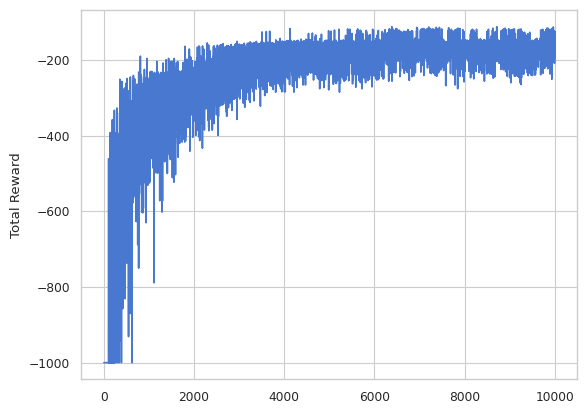

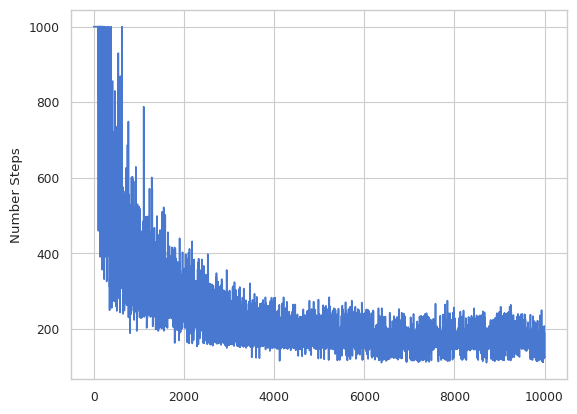

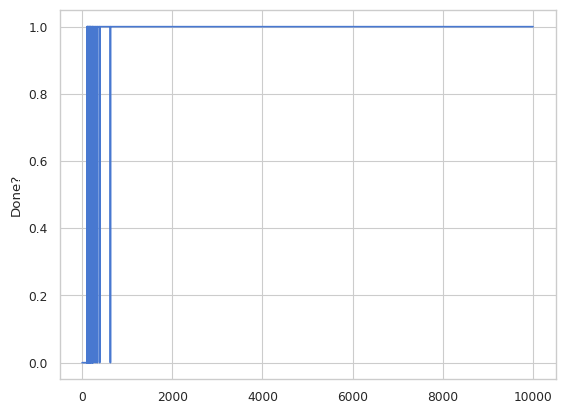

In [ ]:
print(max(arr_total_rewards))

plt.ylabel("Total Reward")
plt.plot(range(0,num_episodes),arr_total_rewards)
plt.show()

plt.ylabel("Number Steps")
plt.plot(range(0,num_episodes),arr_steps)
plt.show()

plt.ylabel("Done?")
plt.plot(range(0,num_episodes),arr_done)
plt.show()

The algorithm clearly converges to a level, showing that the agent learns how to move in the environment.

In [ ]:
# Get the optimal policy
# print(q_table)
optimal_policy = np.zeros((P,V))
for pos in range(P):
    for vel in range(V):
        optimal_policy[pos,vel] = np.argmax(q_table[pos, vel, :])

print(optimal_policy.shape)
print(optimal_policy)

(100, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Although this heatmap is not very intuitive to read, we keep it here because it looks kinda beautiful. Could be considered RL art - "The Lemon in the Mountain Car Problem".

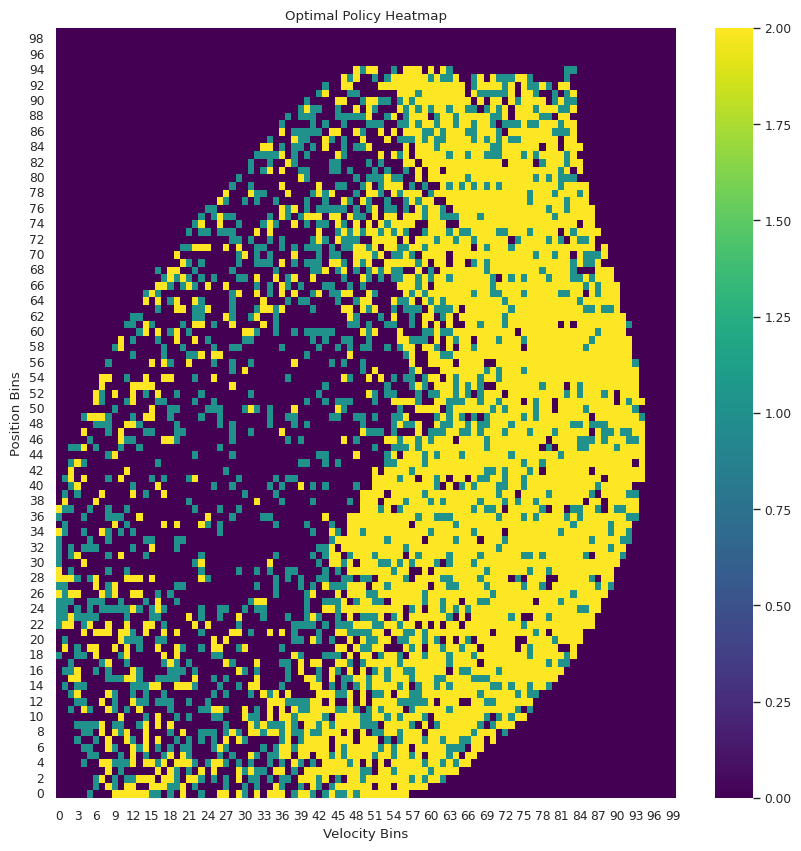

In [ ]:
# Create the heatmap
plt.figure(figsize=(10, 10))  # Adjust the size as needed
ax = sns.heatmap(optimal_policy, cmap="viridis")

# Add titles and labels as needed
plt.title("Optimal Policy Heatmap")
plt.xlabel("Velocity Bins")
plt.ylabel("Position Bins")

# Flip the y-axis
ax.invert_yaxis()

# Show the plot
plt.show()

In [20]:
def run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches):
    global q_table  # Ensure q_table is accessed globally
    q_table = np.zeros((len(position_batches), len(velocity_batches), env.action_space.n))
    arr_total_rewards = []
    arr_steps = []
    arr_done = np.zeros(num_episodes)

    for i in range(num_episodes):
        s, _ = env.reset()
        total_reward = 0
        steps = 0

        s = [get_index_position_batch(s[0], position_batches), get_index_velocity_batch(s[1], velocity_batches)]

        for t in range(num_steps):
            a = epsilon_greedy(s, epsilon)  # Adjusted to two parameters

            s_, r, done, _, _ = env.step(a)
            s_ = [get_index_position_batch(s_[0], position_batches), get_index_velocity_batch(s_[1], velocity_batches)]
            a_ = np.argmax(q_table[s_[0], s_[1], :])

            q_table[s[0], s[1], a] += alpha * (r + gamma * q_table[s_[0], s_[1], a_] - q_table[s[0], s[1], a])
            s = s_
            total_reward += r
            steps += 1

            if done:
                arr_done[i] = 1
                break

        arr_total_rewards.append(total_reward)
        arr_steps.append(steps)

    return q_table, arr_total_rewards, arr_steps

# Grid search
results = {}
for alpha in [0.7, 0.8, 0.9]:
    for gamma in [0.85, 0.9, 0.95]:
        for epsilon in [0.05, 0.1, 0.15]:
            print(f"Running Q-learning for alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
            q_table, total_rewards, steps = run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches)
            results[(alpha, gamma, epsilon)] = {
                'q_table': q_table,
                'total_rewards': total_rewards,
                'steps': steps
            }
            print(f"The highest reward for this configuration is: {max(total_rewards)}")
            print("-----------")

Running Q-learning for alpha=0.7, gamma=0.85, epsilon=0.05
The highest reward for this configuration is: -92.0
-----------
Running Q-learning for alpha=0.7, gamma=0.85, epsilon=0.1
The highest reward for this configuration is: -109.0
-----------
Running Q-learning for alpha=0.7, gamma=0.85, epsilon=0.15
The highest reward for this configuration is: -112.0
-----------
Running Q-learning for alpha=0.7, gamma=0.9, epsilon=0.05
The highest reward for this configuration is: -92.0
-----------
Running Q-learning for alpha=0.7, gamma=0.9, epsilon=0.1
The highest reward for this configuration is: -111.0
-----------
Running Q-learning for alpha=0.7, gamma=0.9, epsilon=0.15
The highest reward for this configuration is: -114.0
-----------
Running Q-learning for alpha=0.7, gamma=0.95, epsilon=0.05
The highest reward for this configuration is: -106.0
-----------
Running Q-learning for alpha=0.7, gamma=0.95, epsilon=0.1
The highest reward for this configuration is: -91.0
-----------
Running Q-learnin

## 2. Deep-Q Learning

- Following [the tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial?hl=en#introduction) and comparing with TP8 notebook, to understand what I'm doing

### Experiments Markdown
- Dedicated cell for saving experiments done, meaning the parameters used and results that we got

---
Exp1 -> DQN Agent
- layers: (100,50)
- iterations: 20k
- learning rate: 0.001

Results:
- best avg return: -124.9

---
Exp2 -> DQN Agent
- layers (50, 25)
- iterations: 30k
- learning rate: 0.001

Results:
- best avg return: -176
- best avg steps: 200

---
Exp3 -> DQN Agent
- layers (100, 50, 25)
- iterations: 30k
- learning rate: 0.001

Results:
- best avg return: -180
- best avg steps: 200

---
Exp4 -> DQN Agent
- layers (100, 50, 5)
- iterations: 30k
- learning rate: 0.001

Results:
- best avg return: -132
- best avg steps: 200

---
Exp5 -> DQN Agent
- layers (100, 50)
- iterations: 150k
- learning rate: 0.001

Results:
- best avg return: -94.0
- best avg steps: 94

---
Exp6 -> DQN Agent
- layers (150, 100)
- iterations: 50k
- learning rate: 0.001

Results:
- best avg return: -111
- best avg steps: 111

---
Exp7 -> DQN Agent
- layers (200, 125, 50)
- iterations: 50k
- learning rate: 0.001

Results:
- best avg return: -103
- best avg steps: 103

---
Exp8 -> DQN Agent
- layers (200, 125, 50)
- iterations: 50k
- learning rate: 0.005

Results:
- best avg return: -189
- best avg steps: 189

---
Exp9 -> DQN Agent
- layers (200, 125, 50)
- iterations: 150k
- learning rate: 0.002

Results:
- best avg return: -121
- best avg steps: 121

---
Exp10 -> DQN Agent
- layers (50, 100, 100, 50)
- iterations: 150k
- learning rate: 0.001

Results:
- best avg return: -146
- best avg steps: 146

---
Exp11 -> DQN Agent
- layers (300, 175, 100)
- iterations: 150k
- learning rate: 0.001

Results:
- best avg return: -199.0
- best avg steps: 199

---
Exp12 -> DQN Agent
- layers (100, 50)
- iterations: 150k
- learning rate: 0.001

Results:
- best avg return: -96
- best avg steps: 96

In [21]:
#
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


### Hyperparameters

In [22]:
dqn_layer_params = (100, 50) #

num_iterations = 150000

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 250

num_episodes = 10
eval_interval = 750

### Env

In [23]:
env_name = "MountainCar-v0"
env_dqn = suite_gym.load(env_name)
env_dqn.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.55657315,  0.        ], dtype=float32)})

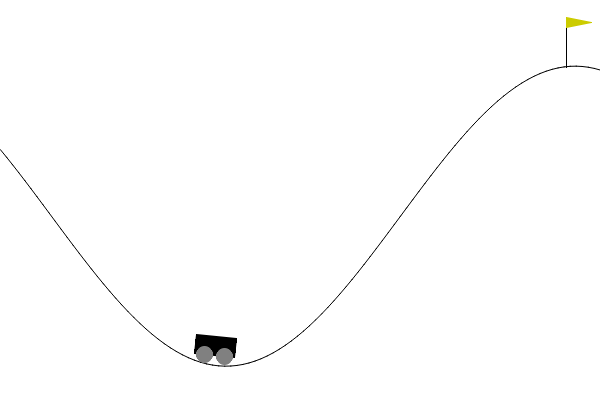

In [24]:
PIL.Image.fromarray(env_dqn.render())

In [25]:
print('Observation Space:')
print(env_dqn.time_step_spec().observation)

print('Action Space:')
print(env_dqn.action_spec())


Observation Space:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])
Action Space:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


### Environments
- written in python, need to be converted to tensorflow environments

In [26]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [27]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agents

#### Layer Funcs

In [28]:
def dense_layer(num_units, name= ""):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      name=name
      ,kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal')
      )

In [29]:
action_tensor_spec = tensor_spec.from_spec(env_dqn.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# hidden layers
dense_layers = [dense_layer(num_unit, f"Layer_{i}") for num_unit,i in zip(dqn_layer_params, range(len(dqn_layer_params)))]

# last layer, with results
q_value_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    name = "q_layer"
    ,kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2)
    )

q_net = sequential.Sequential(dense_layers + [q_value_layer])

### Creating an Agent

In [30]:
# choosing an optimizer, inputing the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# step counter
train_step_counter = tf.Variable(0)

# create the agent object, feeding it with
# observation and action space,
# the network architecture,
# the choosen optimizer and a loss function (TODO we might test multiple?)
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


### Policies

In [31]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [32]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


### Buffer

In [33]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


### Training the agent

In [34]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  total_steps = 0

  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    episode_steps = 0

    while not time_step.is_last():
      episode_steps += 1

      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

    total_return += episode_return
    total_steps += episode_steps
    # print(f"ep steps {episode_steps}")

  avg_return = total_return / num_episodes
  avg_steps = total_steps / num_episodes


  return avg_return.numpy()[0], avg_steps


- Totally need do review this code below, i still don't understand the buffer
- Just copied it to see if it runs on colab!!

In [35]:
py_driver.PyDriver(
    env_dqn,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())


(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.48325977,  0.0069196 ], dtype=float32)}),
 ())

In [36]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


In [37]:
# print(replay_buffer)
# print(dataset)
iterator = iter(dataset)

In [38]:
# Baseline Performance with a random policy for a DQN-Agent
compute_avg_return(eval_env, random_policy, num_episodes)

(-200.0, 200.0)

In [ ]:
# Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return , avg_steps= compute_avg_return(eval_env, agent.policy, num_episodes)
returns = [avg_return]
steps = [avg_steps]
losses = []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_dqn,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  losses.append(train_loss)
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return, avg_steps = compute_avg_return(eval_env, agent.policy, num_episodes)
    print('step = {0}: Average Return = {1}, Average Steps {2}'.format(step, avg_return, avg_steps))
    returns.append(avg_return)
    steps.append(avg_steps)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 250: loss = 0.8902363777160645
step = 500: loss = 1.6220693588256836
step = 750: loss = 1.2932350635528564
step = 750: Average Return = -200.0, Average Steps 200.0
step = 1000: loss = 190.7344207763672
step = 1250: loss = 223.82833862304688
step = 1500: loss = 3.1963486671447754
step = 1500: Average Return = -200.0, Average Steps 200.0
step = 1750: loss = 2.449657440185547
step = 2000: loss = 2.422795534133911
step = 2250: loss = 1.5899161100387573
step = 2250: Average Return = -200.0, Average Steps 200.0
step = 2500: loss = 350.11004638671875
step = 2750: loss = 243.63795471191406
step = 3000: loss = 2.466883420944214
step = 3000: Average Return = -200.0, Average Steps 200.0
step = 3250: loss = 1.2371102571487427
step = 3500: loss = 2.3434009552001953
step = 3750: loss = 1.950278401374817
step = 3750: Average Return = -200.0, Average Steps 200.0
step = 4000: loss = 2.084265947341919
step = 4250: loss = 198.21922302246094
step = 4500: loss = 204.17210388183594
step = 4500: Avera

### Plots

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)

print(f"Best Avg Return: {max(returns)}")
print(f"Best Avg Steps: {min(steps)}")
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=25)
plt.show()

iterations_log = range(0, num_iterations)
plt.scatter(iterations_log, losses)
plt.ylabel('Losses')
plt.xlabel('Iterations')
# plt.ylim(top=250)

### Videos

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)


In [ ]:
def create_policy_eval_video_qlearn(filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):

      video.append_data(env.render())

      #initialize the state by resetting the environment
      s,_ = env.reset()
      total_reward = 0
      steps = 0

      # discretize
      s = [get_index_position_batch(s[0], position_batches), get_index_velocity_batch(s[1], velocity_batches)]

      #for each step in the episode
      for t in range(num_steps):

          #select the action using optimal policy table
          a = int(optimal_policy[s[0], s[1]])

          #perform the selected action and store the next state information
          s_, _ , done, _, _ = env.step(a)

          # discretize
          s_ = [get_index_position_batch(s_[0], position_batches), get_index_velocity_batch(s_[1], velocity_batches)]

          #update current state to next state
          s = s_

          video.append_data(env.render())

          #if the current state is the terminal state then break
          if done:
              break


  return embed_mp4(filename)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, "trained-dqn-agent")

In [ ]:
create_policy_eval_video_qlearn("trained-qlearn-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-dqn-agent")
